In [1]:
import os

import matplotlib
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


# 构建网络模型
class LeNet(nn.Module):  # 继承于nn.Module这个父类
    def __init__(self):  # 初始化网络结构
        super(LeNet, self).__init__()  # 多继承需用到super函数
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),  # 输出为6*28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出为6*14*14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 输出为16*10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出为16*5*5
        )
        self.block_2 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):  # 正向传播过程
        x = self.block_1(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.block_2(x)
        return x

In [11]:
def test(testDataLoader, net, lossF, history, epoch, epochs, device):
    net.eval()  # 切换到测试模式
    test_correct_num = 0
    test_num = 0
    totalLoss = 0
    with torch.no_grad():  # 不更新参数

        processBar = tqdm(testDataLoader, unit='step')
        for step, (test_imgs, labels) in enumerate(processBar):
            test_imgs = test_imgs.to(device)
            labels = labels.to(device)
            output = net(test_imgs)  # 正向传播得到预测值

            loss = lossF(output, labels)
            predictions = torch.argmax(output, dim=1)

            totalLoss += loss
            test_correct_num += torch.sum(predictions == labels)
            test_num += labels.shape[0]

            if step == len(processBar) - 1:
                testAccuracy = test_correct_num / test_num
                testLoss = totalLoss / len(testDataLoader)
                history['Test Loss'][epoch] = testLoss.item()
                history['Test Accuracy'][epoch] = testAccuracy.item()
                processBar.set_description(
                    "[%d/%d] Test Loss: %.4f, Test Acc: %.4f" %
                      (epoch + 1, epochs, testLoss.item(), testAccuracy.item()))


In [3]:
import numpy as np


def update_lr(optimizer, epoch, base_lr, update_epochs=[25], decay_rate=0.1):
    lr = base_lr * (decay_rate ** np.sum(epoch >= np.array(update_epochs)))
    optimizer.lr = lr

In [4]:
def history_plot(history):
    plt.figure(figsize=(12, 12))

    # 绘制训练损失
    plt.subplot(2, 2, 1)
    plt.plot(history['Train Loss'].keys(), history['Train Loss'].values(), label='Train Loss')
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    # 绘制测试损失
    plt.subplot(2, 2, 2)
    plt.plot(history['Test Loss'].keys(), history['Test Loss'].values(), label='Test Loss')
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Testing Loss')

    # 绘制训练精度
    plt.subplot(2, 2, 3)
    plt.plot(history['Train Accuracy'].keys(), history['Train Accuracy'].values(), label='Train Accuracy')
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    # 绘制测试精度
    plt.subplot(2, 2, 4)
    plt.plot(history['Test Accuracy'].keys(), history['Test Accuracy'].values(), label='Test Accuracy')
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')

    # 展示
    plt.tight_layout()
    plt.show()

In [5]:
def train(net, trainDataLoader, testDataLoader, device, batch_size, epochs=60, lr=1e-3, update_epochs=[25], vis=False, save=True):
    # 构建迭代器和损失
    lossF = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.95, weight_decay=1e-3)

    # 模型训练
    global_step = 0
    history = {'Train Loss': {}, 'Train Accuracy': {}, 'Test Loss': {}, 'Test Accuracy': {}}
    for epoch in range(epochs):
        # 更新学习率
        update_lr(optimizer, epoch, base_lr=lr, update_epochs=update_epochs, decay_rate=0.1)
        # 进度条
        processBar = tqdm(trainDataLoader, unit='step')
        net.train(True)
        for step, (train_imgs, labels) in enumerate(processBar):
            global_step += 1
            train_imgs = train_imgs.to(device)
            labels = labels.to(device)
            # 清除梯度
            net.zero_grad()
            # forward之后得到预测值
            output = net(train_imgs)
            # 计算loss
            loss = lossF(output, labels)
            predictions = torch.argmax(output, dim=1)
            accuracy = torch.sum(predictions == labels) / labels.shape[0]
            history['Train Loss'][global_step] = loss.item()
            history['Train Accuracy'][global_step] = accuracy.item()
            # 反向传播
            loss.backward()
            optimizer.step()
            processBar.set_description(
                "[%d/%d] Train Loss: %.4f,  Train Acc: %.4f" % (epoch + 1, epochs, loss.item(), accuracy.item()))

        if save:
            state = {
                'state': net.state_dict(),
                'epoch': epoch  # 将epoch一并保存
            }
            path_model = "./checkpoint/"
            if not os.path.isdir('checkpoint'):
                os.mkdir('./checkpoint')
            torch.save(state, path_model + 'Epoch' + str(epoch) + '.pth')

        test(testDataLoader, net, lossF, history, epoch, epochs, device)

    if vis:
        history_plot(history)

    if save:
        torch.save(net, './model.pth')

    best_epoch = max(history['Test Accuracy'], key=history['Test Accuracy'].get)
    best_accuracy = history['Test Accuracy'][best_epoch]
    print(f'Best Test Accuracy: epoch {best_epoch}, {best_accuracy}')
    return best_epoch, best_accuracy, net, history

In [6]:
# 定义网络在CPU还是GPU中训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# 构建数据集
path = 'E:\data'
train_data = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)  # 训练集
test_data = torchvision.datasets.MNIST(path, train=False, transform=transform)  # 测试集

In [47]:
batch_size = 512
# 构建训练集和测试集的Dataloader
trainDataLoader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


[1/50] Train Loss: 2.0275,  Train Acc: 0.4375: 100%|██████████| 118/118 [00:06<00:00, 16.99step/s]


[1/50] Test Loss: 2.0052, Test Acc: 0.4839


[2/50] Train Loss: 0.2660,  Train Acc: 0.9062: 100%|██████████| 118/118 [00:06<00:00, 17.14step/s]


[2/50] Test Loss: 0.2227, Test Acc: 0.9340


[3/50] Train Loss: 0.1481,  Train Acc: 0.9583: 100%|██████████| 118/118 [00:06<00:00, 17.31step/s]


[3/50] Test Loss: 0.1334, Test Acc: 0.9611


[4/50] Train Loss: 0.1536,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.30step/s]


[4/50] Test Loss: 0.1068, Test Acc: 0.9703


[5/50] Train Loss: 0.1271,  Train Acc: 0.9479: 100%|██████████| 118/118 [00:06<00:00, 17.30step/s]


[5/50] Test Loss: 0.0843, Test Acc: 0.9740


[6/50] Train Loss: 0.0970,  Train Acc: 0.9583: 100%|██████████| 118/118 [00:06<00:00, 17.25step/s]


[6/50] Test Loss: 0.0730, Test Acc: 0.9785


[7/50] Train Loss: 0.1035,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.03step/s]


[7/50] Test Loss: 0.0684, Test Acc: 0.9795


[8/50] Train Loss: 0.0760,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.13step/s]


[8/50] Test Loss: 0.0644, Test Acc: 0.9814


[9/50] Train Loss: 0.0841,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.01step/s]


[9/50] Test Loss: 0.0614, Test Acc: 0.9803


[10/50] Train Loss: 0.0177,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[10/50] Test Loss: 0.0538, Test Acc: 0.9835


[11/50] Train Loss: 0.0285,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.20step/s]


[11/50] Test Loss: 0.0568, Test Acc: 0.9832


[12/50] Train Loss: 0.0611,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[12/50] Test Loss: 0.0510, Test Acc: 0.9841


[13/50] Train Loss: 0.0459,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.31step/s]


[13/50] Test Loss: 0.0477, Test Acc: 0.9857


[14/50] Train Loss: 0.0470,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.19step/s]


[14/50] Test Loss: 0.0493, Test Acc: 0.9846


[15/50] Train Loss: 0.0573,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.26step/s]


[15/50] Test Loss: 0.0466, Test Acc: 0.9860


[16/50] Train Loss: 0.0377,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.24step/s]


[16/50] Test Loss: 0.0432, Test Acc: 0.9866


[17/50] Train Loss: 0.0307,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.28step/s]


[17/50] Test Loss: 0.0403, Test Acc: 0.9869


[18/50] Train Loss: 0.0355,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.34step/s]


[18/50] Test Loss: 0.0401, Test Acc: 0.9870


[19/50] Train Loss: 0.0371,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.09step/s]


[19/50] Test Loss: 0.0378, Test Acc: 0.9885


[20/50] Train Loss: 0.0499,  Train Acc: 0.9688: 100%|██████████| 118/118 [00:06<00:00, 17.00step/s]


[20/50] Test Loss: 0.0393, Test Acc: 0.9875


[21/50] Train Loss: 0.0444,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.28step/s]


[21/50] Test Loss: 0.0374, Test Acc: 0.9886


[22/50] Train Loss: 0.0089,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.23step/s]


[22/50] Test Loss: 0.0393, Test Acc: 0.9865


[23/50] Train Loss: 0.0215,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.27step/s]


[23/50] Test Loss: 0.0386, Test Acc: 0.9875


[24/50] Train Loss: 0.0076,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.23step/s]


[24/50] Test Loss: 0.0343, Test Acc: 0.9887


[25/50] Train Loss: 0.0243,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.22step/s]


[25/50] Test Loss: 0.0353, Test Acc: 0.9890


[26/50] Train Loss: 0.0056,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.07step/s]


[26/50] Test Loss: 0.0364, Test Acc: 0.9879


[27/50] Train Loss: 0.0571,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[27/50] Test Loss: 0.0340, Test Acc: 0.9892


[28/50] Train Loss: 0.0385,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.23step/s]


[28/50] Test Loss: 0.0362, Test Acc: 0.9885


[29/50] Train Loss: 0.0138,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.24step/s]


[29/50] Test Loss: 0.0333, Test Acc: 0.9889


[30/50] Train Loss: 0.0613,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.17step/s]


[30/50] Test Loss: 0.0322, Test Acc: 0.9899


[31/50] Train Loss: 0.0144,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.18step/s]


[31/50] Test Loss: 0.0311, Test Acc: 0.9901


[32/50] Train Loss: 0.0332,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.22step/s]


[32/50] Test Loss: 0.0349, Test Acc: 0.9888


[33/50] Train Loss: 0.0015,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.10step/s]


[33/50] Test Loss: 0.0357, Test Acc: 0.9883


[34/50] Train Loss: 0.0182,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.24step/s]


[34/50] Test Loss: 0.0305, Test Acc: 0.9901


[35/50] Train Loss: 0.0084,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.30step/s]


[35/50] Test Loss: 0.0328, Test Acc: 0.9890


[36/50] Train Loss: 0.0336,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.32step/s]


[36/50] Test Loss: 0.0335, Test Acc: 0.9892


[37/50] Train Loss: 0.0997,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.19step/s]


[37/50] Test Loss: 0.0314, Test Acc: 0.9902


[38/50] Train Loss: 0.0280,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.17step/s]


[38/50] Test Loss: 0.0324, Test Acc: 0.9893


[39/50] Train Loss: 0.0187,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.06step/s]


[39/50] Test Loss: 0.0346, Test Acc: 0.9881


[40/50] Train Loss: 0.0683,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.17step/s]


[40/50] Test Loss: 0.0313, Test Acc: 0.9901


[41/50] Train Loss: 0.0176,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[41/50] Test Loss: 0.0299, Test Acc: 0.9903


[42/50] Train Loss: 0.0145,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.13step/s]


[42/50] Test Loss: 0.0299, Test Acc: 0.9911


[43/50] Train Loss: 0.0106,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.28step/s]


[43/50] Test Loss: 0.0295, Test Acc: 0.9899


[44/50] Train Loss: 0.0078,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.17step/s]


[44/50] Test Loss: 0.0304, Test Acc: 0.9906


[45/50] Train Loss: 0.0186,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[45/50] Test Loss: 0.0311, Test Acc: 0.9909


[46/50] Train Loss: 0.0111,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.10step/s]


[46/50] Test Loss: 0.0322, Test Acc: 0.9890


[47/50] Train Loss: 0.0163,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.25step/s]


[47/50] Test Loss: 0.0302, Test Acc: 0.9906


[48/50] Train Loss: 0.0372,  Train Acc: 0.9792: 100%|██████████| 118/118 [00:06<00:00, 17.21step/s]


[48/50] Test Loss: 0.0312, Test Acc: 0.9896


[49/50] Train Loss: 0.0064,  Train Acc: 1.0000: 100%|██████████| 118/118 [00:06<00:00, 17.33step/s]


[49/50] Test Loss: 0.0296, Test Acc: 0.9908


[50/50] Train Loss: 0.0202,  Train Acc: 0.9896: 100%|██████████| 118/118 [00:06<00:00, 17.28step/s]


[50/50] Test Loss: 0.0295, Test Acc: 0.9904


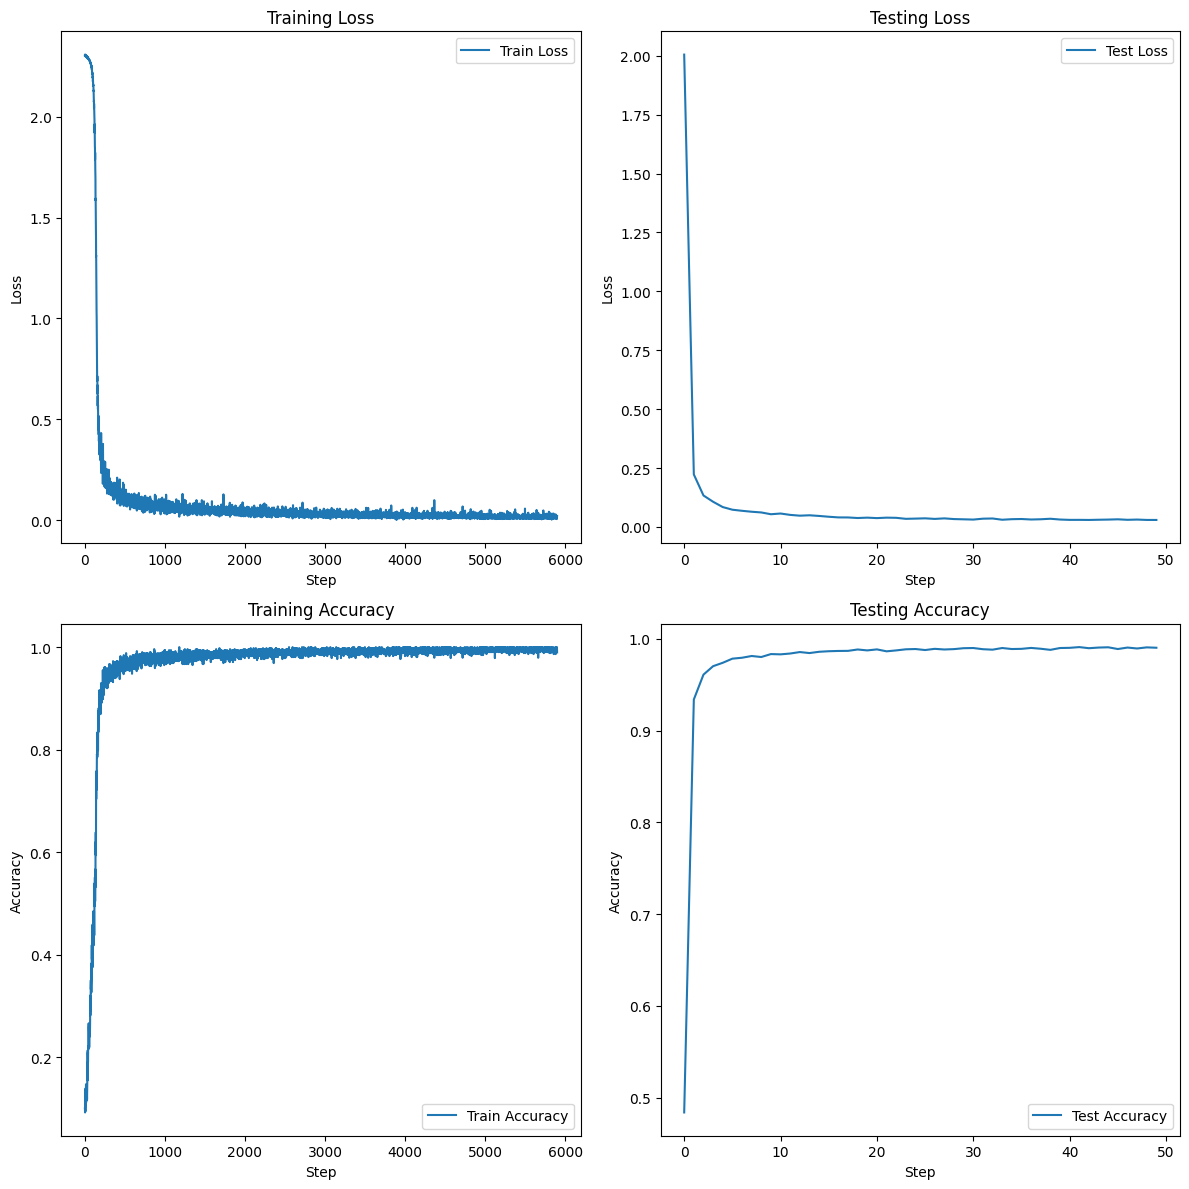

Best Test Accuracy: epoch 41, 0.9910999536514282


(41,
 0.9910999536514282,
 LeNet(
   (block_1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (block_2): Sequential(
     (0): Linear(in_features=400, out_features=120, bias=True)
     (1): ReLU()
     (2): Linear(in_features=120, out_features=84, bias=True)
     (3): ReLU()
     (4): Linear(in_features=84, out_features=10, bias=True)
   )
 ),
 {'Train Loss': {1: 2.3042914867401123,
   2: 2.3077902793884277,
   3: 2.3036000728607178,
   4: 2.3022401332855225,
   5: 2.3046348094940186,
   6: 2.3018486499786377,
   7: 2.303943634033203,
   8: 2.3030781745910645,
   9: 2.2990167140960693,
   10: 2.304363489151001,
   11: 2.30696177482605,
   12: 2.3015754222869873,
   13: 2.299697399

In [48]:
net = LeNet()
net.to(device)  # 将参数送入GPU中
print(net) #输出网络结构
train(
    net=net,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=50,
    device=device,
    lr=4e-3,
    batch_size=512,
    vis=True,
    save=True
)

In [45]:
batch_size = 256
# 构建训练集和测试集的Dataloader
trainDataLoader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


[1/50] Train Loss: 0.5732,  Train Acc: 0.8125: 100%|██████████| 235/235 [00:07<00:00, 32.17step/s]


[1/50] Test Loss: 0.5379, Test Acc: 0.8174


[2/50] Train Loss: 0.1704,  Train Acc: 0.9479: 100%|██████████| 235/235 [00:07<00:00, 31.90step/s]


[2/50] Test Loss: 0.1951, Test Acc: 0.9390


[3/50] Train Loss: 0.0764,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.33step/s]


[3/50] Test Loss: 0.1350, Test Acc: 0.9588


[4/50] Train Loss: 0.0795,  Train Acc: 0.9792: 100%|██████████| 235/235 [00:07<00:00, 31.87step/s]


[4/50] Test Loss: 0.0996, Test Acc: 0.9690


[5/50] Train Loss: 0.1159,  Train Acc: 0.9583: 100%|██████████| 235/235 [00:07<00:00, 32.28step/s]


[5/50] Test Loss: 0.0801, Test Acc: 0.9741


[6/50] Train Loss: 0.1147,  Train Acc: 0.9583: 100%|██████████| 235/235 [00:07<00:00, 32.89step/s]


[6/50] Test Loss: 0.0800, Test Acc: 0.9741


[7/50] Train Loss: 0.0840,  Train Acc: 0.9688: 100%|██████████| 235/235 [00:07<00:00, 32.38step/s]


[7/50] Test Loss: 0.0664, Test Acc: 0.9790


[8/50] Train Loss: 0.1000,  Train Acc: 0.9688: 100%|██████████| 235/235 [00:07<00:00, 32.23step/s]


[8/50] Test Loss: 0.0644, Test Acc: 0.9788


[9/50] Train Loss: 0.0300,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.39step/s]


[9/50] Test Loss: 0.0583, Test Acc: 0.9811


[10/50] Train Loss: 0.0804,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.24step/s]


[10/50] Test Loss: 0.0664, Test Acc: 0.9769


[11/50] Train Loss: 0.1445,  Train Acc: 0.9688: 100%|██████████| 235/235 [00:07<00:00, 31.91step/s]


[11/50] Test Loss: 0.0524, Test Acc: 0.9824


[12/50] Train Loss: 0.0254,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.12step/s]


[12/50] Test Loss: 0.0510, Test Acc: 0.9820


[13/50] Train Loss: 0.1261,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.40step/s]


[13/50] Test Loss: 0.0537, Test Acc: 0.9833


[14/50] Train Loss: 0.0340,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 31.80step/s]


[14/50] Test Loss: 0.0495, Test Acc: 0.9824


[15/50] Train Loss: 0.0419,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 31.85step/s]


[15/50] Test Loss: 0.0450, Test Acc: 0.9844


[16/50] Train Loss: 0.0128,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.29step/s]


[16/50] Test Loss: 0.0443, Test Acc: 0.9856


[17/50] Train Loss: 0.0223,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.03step/s]


[17/50] Test Loss: 0.0448, Test Acc: 0.9854


[18/50] Train Loss: 0.0237,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.31step/s]


[18/50] Test Loss: 0.0389, Test Acc: 0.9863


[19/50] Train Loss: 0.0523,  Train Acc: 0.9792: 100%|██████████| 235/235 [00:07<00:00, 33.03step/s]


[19/50] Test Loss: 0.0398, Test Acc: 0.9876


[20/50] Train Loss: 0.0297,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 33.09step/s]


[20/50] Test Loss: 0.0409, Test Acc: 0.9865


[21/50] Train Loss: 0.0256,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.95step/s]


[21/50] Test Loss: 0.0383, Test Acc: 0.9876


[22/50] Train Loss: 0.0378,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 33.14step/s]


[22/50] Test Loss: 0.0393, Test Acc: 0.9866


[23/50] Train Loss: 0.0389,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 33.14step/s]


[23/50] Test Loss: 0.0390, Test Acc: 0.9868


[24/50] Train Loss: 0.0091,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 33.24step/s]


[24/50] Test Loss: 0.0378, Test Acc: 0.9867


[25/50] Train Loss: 0.0128,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 33.01step/s]


[25/50] Test Loss: 0.0357, Test Acc: 0.9882


[26/50] Train Loss: 0.1905,  Train Acc: 0.9792: 100%|██████████| 235/235 [00:07<00:00, 33.03step/s]


[26/50] Test Loss: 0.0350, Test Acc: 0.9885


[27/50] Train Loss: 0.0180,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.98step/s]


[27/50] Test Loss: 0.0349, Test Acc: 0.9876


[28/50] Train Loss: 0.0331,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.81step/s]


[28/50] Test Loss: 0.0350, Test Acc: 0.9879


[29/50] Train Loss: 0.0133,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.64step/s]


[29/50] Test Loss: 0.0355, Test Acc: 0.9878


[30/50] Train Loss: 0.0357,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.59step/s]


[30/50] Test Loss: 0.0330, Test Acc: 0.9890


[31/50] Train Loss: 0.0244,  Train Acc: 0.9792: 100%|██████████| 235/235 [00:07<00:00, 32.64step/s]


[31/50] Test Loss: 0.0358, Test Acc: 0.9875


[32/50] Train Loss: 0.0138,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.71step/s]


[32/50] Test Loss: 0.0344, Test Acc: 0.9880


[33/50] Train Loss: 0.0092,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.85step/s]


[33/50] Test Loss: 0.0333, Test Acc: 0.9890


[34/50] Train Loss: 0.0088,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.89step/s]


[34/50] Test Loss: 0.0315, Test Acc: 0.9891


[35/50] Train Loss: 0.0098,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.83step/s]


[35/50] Test Loss: 0.0349, Test Acc: 0.9879


[36/50] Train Loss: 0.0087,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 33.11step/s]


[36/50] Test Loss: 0.0344, Test Acc: 0.9889


[37/50] Train Loss: 0.0090,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.91step/s]


[37/50] Test Loss: 0.0349, Test Acc: 0.9880


[38/50] Train Loss: 0.0203,  Train Acc: 0.9792: 100%|██████████| 235/235 [00:07<00:00, 32.60step/s]


[38/50] Test Loss: 0.0314, Test Acc: 0.9898


[39/50] Train Loss: 0.0114,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.99step/s]


[39/50] Test Loss: 0.0317, Test Acc: 0.9897


[40/50] Train Loss: 0.0540,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.71step/s]


[40/50] Test Loss: 0.0338, Test Acc: 0.9884


[41/50] Train Loss: 0.0222,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.77step/s]


[41/50] Test Loss: 0.0337, Test Acc: 0.9884


[42/50] Train Loss: 0.0267,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.75step/s]


[42/50] Test Loss: 0.0330, Test Acc: 0.9895


[43/50] Train Loss: 0.0092,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.81step/s]


[43/50] Test Loss: 0.0327, Test Acc: 0.9896


[44/50] Train Loss: 0.0104,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.61step/s]


[44/50] Test Loss: 0.0313, Test Acc: 0.9896


[45/50] Train Loss: 0.0215,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.78step/s]


[45/50] Test Loss: 0.0314, Test Acc: 0.9898


[46/50] Train Loss: 0.0208,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.56step/s]


[46/50] Test Loss: 0.0318, Test Acc: 0.9890


[47/50] Train Loss: 0.0172,  Train Acc: 0.9896: 100%|██████████| 235/235 [00:07<00:00, 32.94step/s]


[47/50] Test Loss: 0.0377, Test Acc: 0.9876


[48/50] Train Loss: 0.0060,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.89step/s]


[48/50] Test Loss: 0.0307, Test Acc: 0.9895


[49/50] Train Loss: 0.0055,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.77step/s]


[49/50] Test Loss: 0.0305, Test Acc: 0.9901


[50/50] Train Loss: 0.0058,  Train Acc: 1.0000: 100%|██████████| 235/235 [00:07<00:00, 32.80step/s]


[50/50] Test Loss: 0.0335, Test Acc: 0.9878


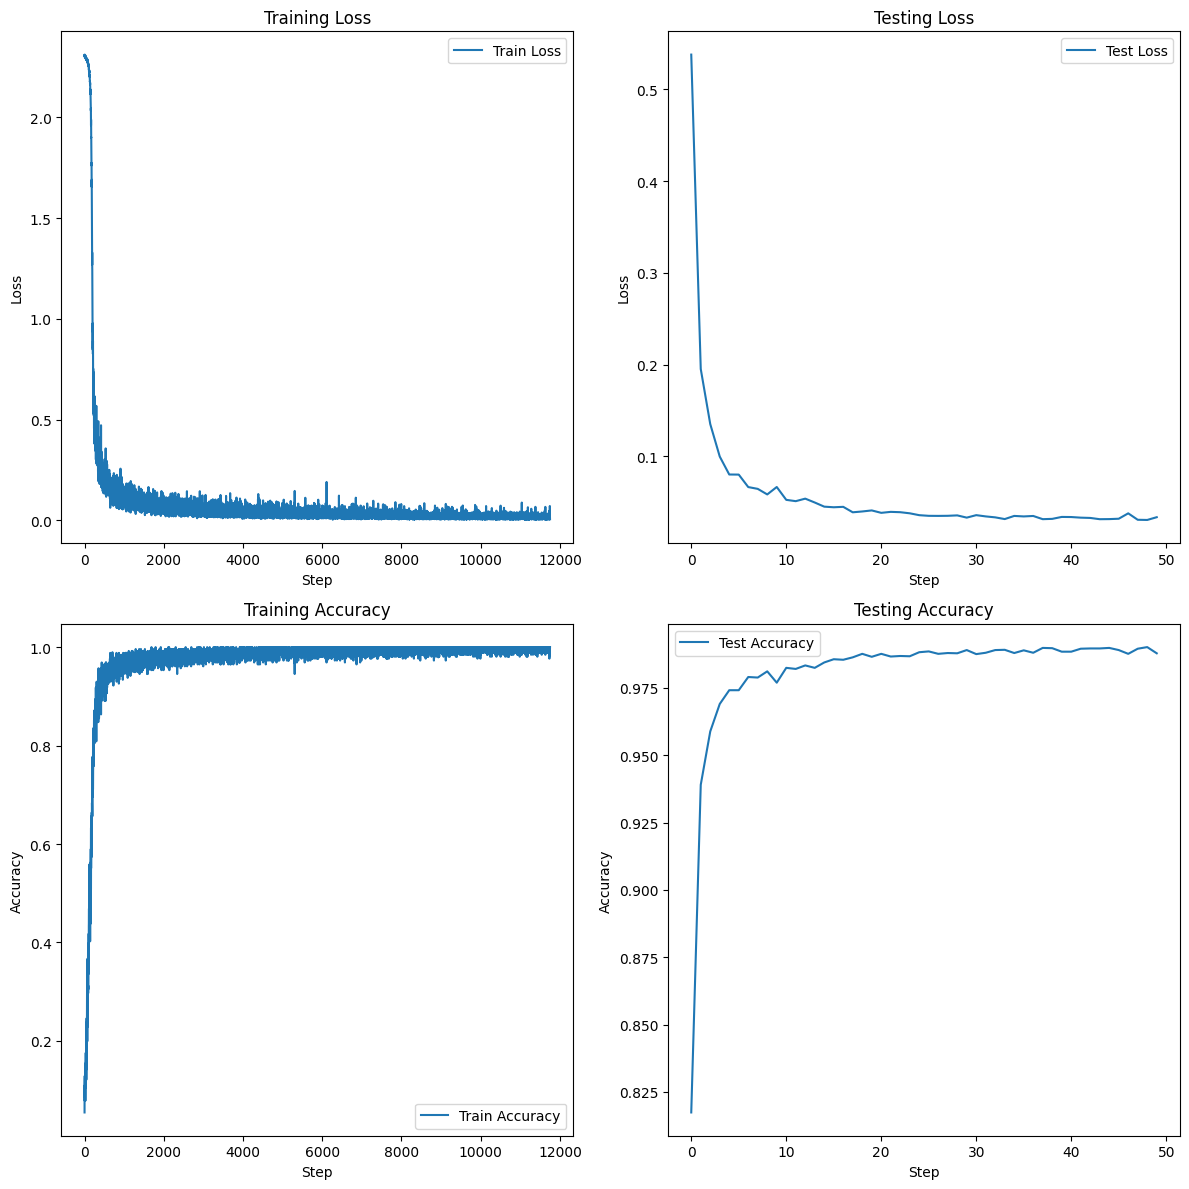

Best Test Accuracy: epoch 48, 0.9900999665260315


(48,
 0.9900999665260315,
 LeNet(
   (block_1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (block_2): Sequential(
     (0): Linear(in_features=400, out_features=120, bias=True)
     (1): ReLU()
     (2): Linear(in_features=120, out_features=84, bias=True)
     (3): ReLU()
     (4): Linear(in_features=84, out_features=10, bias=True)
   )
 ),
 {'Train Loss': {1: 2.3081090450286865,
   2: 2.305162191390991,
   3: 2.3082425594329834,
   4: 2.3109307289123535,
   5: 2.305981159210205,
   6: 2.2997984886169434,
   7: 2.3032681941986084,
   8: 2.3061795234680176,
   9: 2.3044071197509766,
   10: 2.2975809574127197,
   11: 2.3086655139923096,
   12: 2.297657012939453,
   13: 2.30107045

In [46]:
net = LeNet()
net.to(device)  # 将参数送入GPU中
print(net) #输出网络结构
train(
    net=net,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=50,
    lr=2e-3,
    device=device,
    batch_size=256,
    vis=True,
    save=True
)

In [41]:
batch_size = 128
# 构建训练集和测试集的Dataloader
trainDataLoader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


[1/50] Train Loss: 0.8254,  Train Acc: 0.7917: 100%|██████████| 469/469 [00:08<00:00, 55.03step/s]


[1/50] Test Loss: 0.7076, Test Acc: 0.8130


[2/50] Train Loss: 0.1041,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 54.97step/s]


[2/50] Test Loss: 0.1759, Test Acc: 0.9485


[3/50] Train Loss: 0.1512,  Train Acc: 0.9479: 100%|██████████| 469/469 [00:08<00:00, 54.79step/s]


[3/50] Test Loss: 0.1206, Test Acc: 0.9650


[4/50] Train Loss: 0.1185,  Train Acc: 0.9583: 100%|██████████| 469/469 [00:08<00:00, 54.96step/s]


[4/50] Test Loss: 0.0946, Test Acc: 0.9708


[5/50] Train Loss: 0.1438,  Train Acc: 0.9479: 100%|██████████| 469/469 [00:08<00:00, 54.13step/s]


[5/50] Test Loss: 0.0823, Test Acc: 0.9752


[6/50] Train Loss: 0.0639,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 54.55step/s]


[6/50] Test Loss: 0.0741, Test Acc: 0.9758


[7/50] Train Loss: 0.1039,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:14<00:00, 31.85step/s]


[7/50] Test Loss: 0.0650, Test Acc: 0.9801


[8/50] Train Loss: 0.0606,  Train Acc: 0.9688: 100%|██████████| 469/469 [00:13<00:00, 33.84step/s]


[8/50] Test Loss: 0.0626, Test Acc: 0.9792


[9/50] Train Loss: 0.1670,  Train Acc: 0.9583: 100%|██████████| 469/469 [00:08<00:00, 55.97step/s]


[9/50] Test Loss: 0.0777, Test Acc: 0.9758


[10/50] Train Loss: 0.0893,  Train Acc: 0.9688: 100%|██████████| 469/469 [00:08<00:00, 55.71step/s]


[10/50] Test Loss: 0.0516, Test Acc: 0.9841


[11/50] Train Loss: 0.0991,  Train Acc: 0.9583: 100%|██████████| 469/469 [00:08<00:00, 55.49step/s]


[11/50] Test Loss: 0.0475, Test Acc: 0.9853


[12/50] Train Loss: 0.0846,  Train Acc: 0.9583: 100%|██████████| 469/469 [00:08<00:00, 54.73step/s]


[12/50] Test Loss: 0.0440, Test Acc: 0.9853


[13/50] Train Loss: 0.0827,  Train Acc: 0.9583: 100%|██████████| 469/469 [00:08<00:00, 56.11step/s]


[13/50] Test Loss: 0.0420, Test Acc: 0.9857


[14/50] Train Loss: 0.0476,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 53.36step/s]


[14/50] Test Loss: 0.0455, Test Acc: 0.9856


[15/50] Train Loss: 0.0540,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:14<00:00, 31.28step/s]


[15/50] Test Loss: 0.0438, Test Acc: 0.9852


[16/50] Train Loss: 0.0336,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:14<00:00, 31.49step/s]


[16/50] Test Loss: 0.0404, Test Acc: 0.9860


[17/50] Train Loss: 0.0207,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:14<00:00, 32.16step/s]


[17/50] Test Loss: 0.0374, Test Acc: 0.9870


[18/50] Train Loss: 0.0167,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:14<00:00, 31.89step/s]


[18/50] Test Loss: 0.0361, Test Acc: 0.9872


[19/50] Train Loss: 0.0163,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:14<00:00, 31.62step/s]


[19/50] Test Loss: 0.0344, Test Acc: 0.9883


[20/50] Train Loss: 0.0258,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:14<00:00, 31.61step/s]


[20/50] Test Loss: 0.0355, Test Acc: 0.9878


[21/50] Train Loss: 0.1586,  Train Acc: 0.9479: 100%|██████████| 469/469 [00:10<00:00, 46.60step/s]


[21/50] Test Loss: 0.0359, Test Acc: 0.9875


[22/50] Train Loss: 0.0086,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 54.43step/s]


[22/50] Test Loss: 0.0335, Test Acc: 0.9880


[23/50] Train Loss: 0.0245,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.66step/s]


[23/50] Test Loss: 0.0327, Test Acc: 0.9880


[24/50] Train Loss: 0.0355,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.55step/s]


[24/50] Test Loss: 0.0300, Test Acc: 0.9892


[25/50] Train Loss: 0.0031,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 55.40step/s]


[25/50] Test Loss: 0.0297, Test Acc: 0.9889


[26/50] Train Loss: 0.0344,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 55.30step/s]


[26/50] Test Loss: 0.0299, Test Acc: 0.9895


[27/50] Train Loss: 0.0210,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.10step/s]


[27/50] Test Loss: 0.0328, Test Acc: 0.9885


[28/50] Train Loss: 0.0072,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 55.23step/s]


[28/50] Test Loss: 0.0301, Test Acc: 0.9885


[29/50] Train Loss: 0.0349,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.50step/s]


[29/50] Test Loss: 0.0296, Test Acc: 0.9902


[30/50] Train Loss: 0.0209,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 55.95step/s]


[30/50] Test Loss: 0.0305, Test Acc: 0.9890


[31/50] Train Loss: 0.0220,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 56.10step/s]


[31/50] Test Loss: 0.0304, Test Acc: 0.9888


[32/50] Train Loss: 0.0300,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.95step/s]


[32/50] Test Loss: 0.0304, Test Acc: 0.9889


[33/50] Train Loss: 0.0274,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 53.89step/s]


[33/50] Test Loss: 0.0309, Test Acc: 0.9892


[34/50] Train Loss: 0.0049,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 54.22step/s]


[34/50] Test Loss: 0.0277, Test Acc: 0.9897


[35/50] Train Loss: 0.0135,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.93step/s]


[35/50] Test Loss: 0.0290, Test Acc: 0.9902


[36/50] Train Loss: 0.0315,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.50step/s]


[36/50] Test Loss: 0.0299, Test Acc: 0.9894


[37/50] Train Loss: 0.0077,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 55.64step/s]


[37/50] Test Loss: 0.0291, Test Acc: 0.9899


[38/50] Train Loss: 0.0452,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 55.41step/s]


[38/50] Test Loss: 0.0299, Test Acc: 0.9894


[39/50] Train Loss: 0.0538,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 54.95step/s]


[39/50] Test Loss: 0.0282, Test Acc: 0.9899


[40/50] Train Loss: 0.0232,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 52.34step/s]


[40/50] Test Loss: 0.0274, Test Acc: 0.9901


[41/50] Train Loss: 0.0014,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 54.22step/s]


[41/50] Test Loss: 0.0262, Test Acc: 0.9902


[42/50] Train Loss: 0.0149,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 54.75step/s]


[42/50] Test Loss: 0.0285, Test Acc: 0.9897


[43/50] Train Loss: 0.0150,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.50step/s]


[43/50] Test Loss: 0.0279, Test Acc: 0.9898


[44/50] Train Loss: 0.0119,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 54.72step/s]


[44/50] Test Loss: 0.0272, Test Acc: 0.9897


[45/50] Train Loss: 0.0172,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 54.42step/s]


[45/50] Test Loss: 0.0264, Test Acc: 0.9907


[46/50] Train Loss: 0.0309,  Train Acc: 0.9792: 100%|██████████| 469/469 [00:08<00:00, 56.52step/s]


[46/50] Test Loss: 0.0253, Test Acc: 0.9907


[47/50] Train Loss: 0.0178,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.36step/s]


[47/50] Test Loss: 0.0273, Test Acc: 0.9904


[48/50] Train Loss: 0.0056,  Train Acc: 1.0000: 100%|██████████| 469/469 [00:08<00:00, 55.61step/s]


[48/50] Test Loss: 0.0273, Test Acc: 0.9904


[49/50] Train Loss: 0.0385,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.96step/s]


[49/50] Test Loss: 0.0271, Test Acc: 0.9893


[50/50] Train Loss: 0.0180,  Train Acc: 0.9896: 100%|██████████| 469/469 [00:08<00:00, 55.48step/s]


[50/50] Test Loss: 0.0291, Test Acc: 0.9904


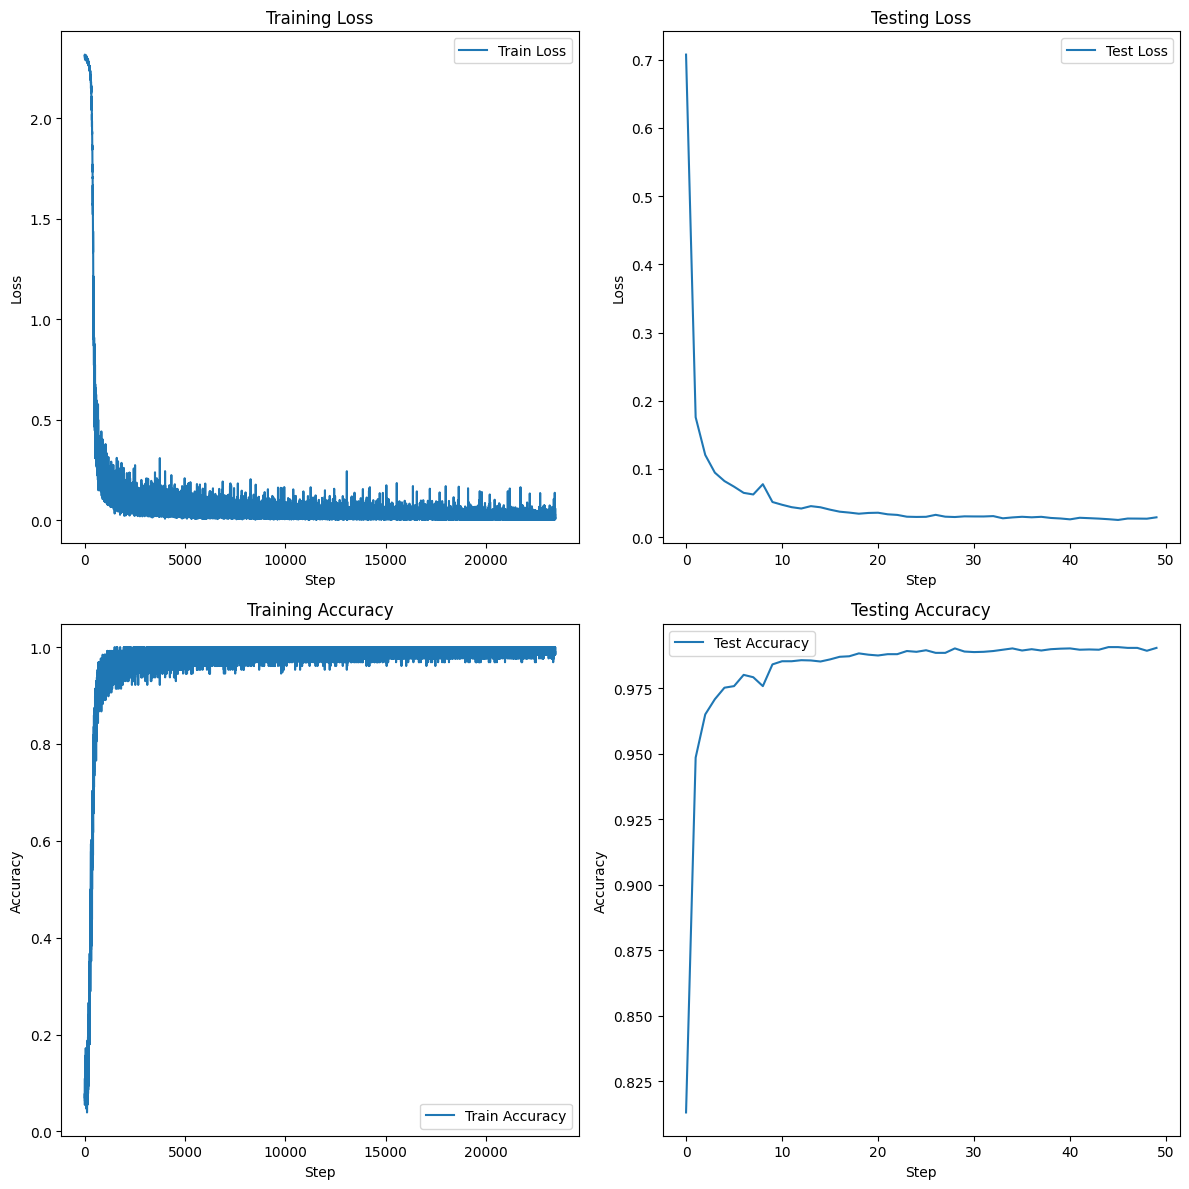

Best Test Accuracy: epoch 44, 0.9906999468803406


(44,
 0.9906999468803406,
 LeNet(
   (block_1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (block_2): Sequential(
     (0): Linear(in_features=400, out_features=120, bias=True)
     (1): ReLU()
     (2): Linear(in_features=120, out_features=84, bias=True)
     (3): ReLU()
     (4): Linear(in_features=84, out_features=10, bias=True)
   )
 ),
 {'Train Loss': {1: 2.302626132965088,
   2: 2.3056046962738037,
   3: 2.3157434463500977,
   4: 2.3067467212677,
   5: 2.306697130203247,
   6: 2.293224811553955,
   7: 2.3103320598602295,
   8: 2.2951457500457764,
   9: 2.313939332962036,
   10: 2.2973859310150146,
   11: 2.292628765106201,
   12: 2.297018051147461,
   13: 2.30428934097290

In [42]:
net = LeNet()
net.to(device)  # 将参数送入GPU中
print(net) #输出网络结构
train(
    net=net,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=50,
    device=device,
    batch_size=128,
    vis=True,
    save=True
)

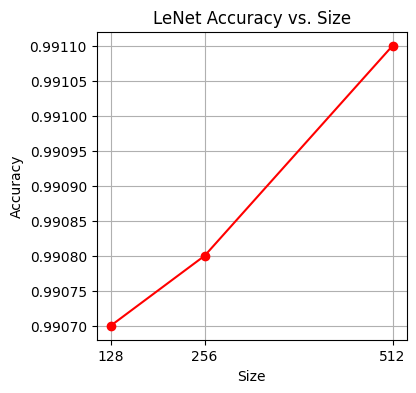

In [24]:
import matplotlib.pyplot as plt

lenet_accuracy = {128: 0.9906999468803406, 256: 0.9907999665260315, 512: 0.9910999536514282}

# Extracting values from the dictionary
sizes = list(lenet_accuracy.keys())
accuracies = list(lenet_accuracy.values())

plt.figure(figsize=(4, 4))

# Plotting the line chart with only keys on the x-axis
plt.plot(sizes, accuracies, marker='o', linestyle='-', color='r')
plt.title('LeNet Accuracy vs. Size')
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.xticks(sizes)  # Set x-axis ticks to be the keys
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision import datasets
from torchvision.transforms import transforms


def KFoldTest(model, num_folds=5, batch_size=256):
    # Define transformations for MNIST
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load MNIST dataset
    mnist_dataset = datasets.MNIST(root='E:/data/', train=True, download=True, transform=transform)

    # Define Cross-Validation Splitter
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    kflod_best_accuracy = []

    # Loop over folds
    for fold, (train_indices, test_indices) in enumerate(kfold.split(mnist_dataset.data, mnist_dataset.targets)):
        print(f'Fold {fold + 1}/{num_folds}')

        # Create DataLoader for training and testing sets
        train_data = torch.utils.data.Subset(mnist_dataset, train_indices)
        test_data = torch.utils.data.Subset(mnist_dataset, test_indices)

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

        # Create a new instance of the model for each fold
        net = model()
        net = net.to(device)

        # Train the model
        best_epoch, best_accuracy, history, net = train(net, train_loader, test_loader, device, batch_size, epochs=20, save=0, vis=0)
        kflod_best_accuracy.append({
            'best_epoch': best_epoch,
            'best_accuracy': best_accuracy,
            'history': history,
            'net': net
        })

        # Display results for the current fold
        print(f'Fold {fold + 1} Results:')
        print(f'Best Test Accuracy: {best_accuracy}')
        print('-----------------------------')

    return kflod_best_accuracy

In [12]:
kflod_best_accuracy = KFoldTest(LeNet, num_folds=5, batch_size=512)

Fold 1/5


[1/20] Train Loss: 2.2988,  Train Acc: 0.1042: 100%|██████████| 94/94 [00:05<00:00, 16.48step/s]


[1/20] Test Loss: 2.2965, Test Acc: 0.1120


[2/20] Train Loss: 2.2788,  Train Acc: 0.2656: 100%|██████████| 94/94 [00:05<00:00, 16.68step/s]


[2/20] Test Loss: 2.2816, Test Acc: 0.2205


[3/20] Train Loss: 2.2501,  Train Acc: 0.4141: 100%|██████████| 94/94 [00:05<00:00, 16.76step/s]


[3/20] Test Loss: 2.2495, Test Acc: 0.3930


[4/20] Train Loss: 2.1206,  Train Acc: 0.5260: 100%|██████████| 94/94 [00:05<00:00, 16.68step/s]


[4/20] Test Loss: 2.1260, Test Acc: 0.4916


[5/20] Train Loss: 1.1907,  Train Acc: 0.7292: 100%|██████████| 94/94 [00:05<00:00, 16.69step/s]


[5/20] Test Loss: 1.1928, Test Acc: 0.7116


[6/20] Train Loss: 0.4953,  Train Acc: 0.8516: 100%|██████████| 94/94 [00:05<00:00, 16.85step/s]


[6/20] Test Loss: 0.4573, Test Acc: 0.8494


[7/20] Train Loss: 0.3217,  Train Acc: 0.9062: 100%|██████████| 94/94 [00:05<00:00, 16.89step/s]


[7/20] Test Loss: 0.3181, Test Acc: 0.8859


[8/20] Train Loss: 0.2477,  Train Acc: 0.9193: 100%|██████████| 94/94 [00:05<00:00, 16.74step/s]


[8/20] Test Loss: 0.2451, Test Acc: 0.9058


[9/20] Train Loss: 0.2820,  Train Acc: 0.9219: 100%|██████████| 94/94 [00:05<00:00, 16.71step/s]


[9/20] Test Loss: 0.2041, Test Acc: 0.9168


[10/20] Train Loss: 0.1595,  Train Acc: 0.9401: 100%|██████████| 94/94 [00:05<00:00, 16.56step/s]


[10/20] Test Loss: 0.1808, Test Acc: 0.9225


[11/20] Train Loss: 0.1898,  Train Acc: 0.9401: 100%|██████████| 94/94 [00:05<00:00, 16.60step/s]


[11/20] Test Loss: 0.1618, Test Acc: 0.9287


[12/20] Train Loss: 0.1233,  Train Acc: 0.9661: 100%|██████████| 94/94 [00:05<00:00, 16.80step/s]


[12/20] Test Loss: 0.1508, Test Acc: 0.9317


[13/20] Train Loss: 0.0897,  Train Acc: 0.9661: 100%|██████████| 94/94 [00:05<00:00, 16.48step/s]


[13/20] Test Loss: 0.1358, Test Acc: 0.9372


[14/20] Train Loss: 0.0878,  Train Acc: 0.9766: 100%|██████████| 94/94 [00:05<00:00, 16.67step/s]


[14/20] Test Loss: 0.1282, Test Acc: 0.9388


[15/20] Train Loss: 0.0935,  Train Acc: 0.9714: 100%|██████████| 94/94 [00:05<00:00, 16.76step/s]


[15/20] Test Loss: 0.1207, Test Acc: 0.9411


[16/20] Train Loss: 0.0906,  Train Acc: 0.9688: 100%|██████████| 94/94 [00:05<00:00, 16.68step/s]


[16/20] Test Loss: 0.1197, Test Acc: 0.9420


[17/20] Train Loss: 0.0973,  Train Acc: 0.9740: 100%|██████████| 94/94 [00:05<00:00, 16.59step/s]


[17/20] Test Loss: 0.1142, Test Acc: 0.9434


[18/20] Train Loss: 0.1010,  Train Acc: 0.9688: 100%|██████████| 94/94 [00:05<00:00, 16.65step/s]


[18/20] Test Loss: 0.1079, Test Acc: 0.9457


[19/20] Train Loss: 0.0990,  Train Acc: 0.9714: 100%|██████████| 94/94 [00:05<00:00, 16.66step/s]


[19/20] Test Loss: 0.1025, Test Acc: 0.9464


[20/20] Train Loss: 0.1229,  Train Acc: 0.9557: 100%|██████████| 94/94 [00:05<00:00, 16.85step/s]


[20/20] Test Loss: 0.1004, Test Acc: 0.9481
Best Test Accuracy: epoch 19, 0.9480794668197632
Fold 1 Results:
Best Test Accuracy: 0.9480794668197632
-----------------------------
Fold 2/5


[1/20] Train Loss: 2.2877,  Train Acc: 0.1849: 100%|██████████| 94/94 [00:05<00:00, 16.91step/s]


[1/20] Test Loss: 2.2912, Test Acc: 0.1758


[2/20] Train Loss: 2.2713,  Train Acc: 0.2734: 100%|██████████| 94/94 [00:05<00:00, 16.76step/s]


[2/20] Test Loss: 2.2694, Test Acc: 0.2740


[3/20] Train Loss: 2.2051,  Train Acc: 0.5130: 100%|██████████| 94/94 [00:05<00:00, 16.92step/s]


[3/20] Test Loss: 2.2064, Test Acc: 0.5028


[4/20] Train Loss: 1.8054,  Train Acc: 0.6198: 100%|██████████| 94/94 [00:05<00:00, 16.27step/s]


[4/20] Test Loss: 1.7870, Test Acc: 0.6065


[5/20] Train Loss: 0.6029,  Train Acc: 0.8281: 100%|██████████| 94/94 [00:05<00:00, 16.60step/s]


[5/20] Test Loss: 0.6026, Test Acc: 0.8101


[6/20] Train Loss: 0.4743,  Train Acc: 0.8776: 100%|██████████| 94/94 [00:05<00:00, 16.76step/s]


[6/20] Test Loss: 0.3695, Test Acc: 0.8732


[7/20] Train Loss: 0.3103,  Train Acc: 0.8880: 100%|██████████| 94/94 [00:05<00:00, 16.91step/s]


[7/20] Test Loss: 0.2971, Test Acc: 0.8901


[8/20] Train Loss: 0.2985,  Train Acc: 0.9062: 100%|██████████| 94/94 [00:05<00:00, 16.62step/s]


[8/20] Test Loss: 0.2572, Test Acc: 0.9018


[9/20] Train Loss: 0.2225,  Train Acc: 0.9375: 100%|██████████| 94/94 [00:05<00:00, 16.75step/s]


[9/20] Test Loss: 0.2273, Test Acc: 0.9106


[10/20] Train Loss: 0.2290,  Train Acc: 0.9349: 100%|██████████| 94/94 [00:05<00:00, 16.63step/s]


[10/20] Test Loss: 0.2050, Test Acc: 0.9164


[11/20] Train Loss: 0.1959,  Train Acc: 0.9401: 100%|██████████| 94/94 [00:05<00:00, 16.55step/s]


[11/20] Test Loss: 0.1880, Test Acc: 0.9189


[12/20] Train Loss: 0.1788,  Train Acc: 0.9583: 100%|██████████| 94/94 [00:05<00:00, 16.04step/s]


[12/20] Test Loss: 0.1856, Test Acc: 0.9197


[13/20] Train Loss: 0.1951,  Train Acc: 0.9453: 100%|██████████| 94/94 [00:05<00:00, 16.22step/s]


[13/20] Test Loss: 0.1599, Test Acc: 0.9297


[14/20] Train Loss: 0.1408,  Train Acc: 0.9635: 100%|██████████| 94/94 [00:05<00:00, 16.70step/s]


[14/20] Test Loss: 0.1520, Test Acc: 0.9335


[15/20] Train Loss: 0.1826,  Train Acc: 0.9349: 100%|██████████| 94/94 [00:05<00:00, 16.80step/s]


[15/20] Test Loss: 0.1415, Test Acc: 0.9344


[16/20] Train Loss: 0.1384,  Train Acc: 0.9531: 100%|██████████| 94/94 [00:05<00:00, 16.30step/s]


[16/20] Test Loss: 0.1387, Test Acc: 0.9355


[17/20] Train Loss: 0.1288,  Train Acc: 0.9661: 100%|██████████| 94/94 [00:05<00:00, 16.23step/s]


[17/20] Test Loss: 0.1305, Test Acc: 0.9374


[18/20] Train Loss: 0.1150,  Train Acc: 0.9688: 100%|██████████| 94/94 [00:05<00:00, 16.38step/s]


[18/20] Test Loss: 0.1257, Test Acc: 0.9394


[19/20] Train Loss: 0.0805,  Train Acc: 0.9766: 100%|██████████| 94/94 [00:05<00:00, 16.79step/s]


[19/20] Test Loss: 0.1203, Test Acc: 0.9418


[20/20] Train Loss: 0.1240,  Train Acc: 0.9792: 100%|██████████| 94/94 [00:05<00:00, 16.62step/s]


[20/20] Test Loss: 0.1164, Test Acc: 0.9425
Best Test Accuracy: epoch 19, 0.9424642324447632
Fold 2 Results:
Best Test Accuracy: 0.9424642324447632
-----------------------------
Fold 3/5


[1/20] Train Loss: 2.2990,  Train Acc: 0.1693: 100%|██████████| 94/94 [00:05<00:00, 16.71step/s]


[1/20] Test Loss: 2.2964, Test Acc: 0.1595


[2/20] Train Loss: 2.2867,  Train Acc: 0.2396: 100%|██████████| 94/94 [00:05<00:00, 16.71step/s]


[2/20] Test Loss: 2.2864, Test Acc: 0.2486


[3/20] Train Loss: 2.2663,  Train Acc: 0.4401: 100%|██████████| 94/94 [00:05<00:00, 16.54step/s]


[3/20] Test Loss: 2.2673, Test Acc: 0.4248


[4/20] Train Loss: 2.2092,  Train Acc: 0.5182: 100%|██████████| 94/94 [00:05<00:00, 16.54step/s]


[4/20] Test Loss: 2.2102, Test Acc: 0.4809


[5/20] Train Loss: 1.7908,  Train Acc: 0.7318: 100%|██████████| 94/94 [00:05<00:00, 16.72step/s]


[5/20] Test Loss: 1.8223, Test Acc: 0.6521


[6/20] Train Loss: 0.6742,  Train Acc: 0.8151: 100%|██████████| 94/94 [00:05<00:00, 16.67step/s]


[6/20] Test Loss: 0.6678, Test Acc: 0.7838


[7/20] Train Loss: 0.3095,  Train Acc: 0.9062: 100%|██████████| 94/94 [00:05<00:00, 16.99step/s]


[7/20] Test Loss: 0.4122, Test Acc: 0.8553


[8/20] Train Loss: 0.3224,  Train Acc: 0.9141: 100%|██████████| 94/94 [00:05<00:00, 16.56step/s]


[8/20] Test Loss: 0.3097, Test Acc: 0.8836


[9/20] Train Loss: 0.2760,  Train Acc: 0.9115: 100%|██████████| 94/94 [00:05<00:00, 16.57step/s]


[9/20] Test Loss: 0.2592, Test Acc: 0.9017


[10/20] Train Loss: 0.3305,  Train Acc: 0.8906: 100%|██████████| 94/94 [00:05<00:00, 16.50step/s]


[10/20] Test Loss: 0.2292, Test Acc: 0.9072


[11/20] Train Loss: 0.2390,  Train Acc: 0.9323: 100%|██████████| 94/94 [00:05<00:00, 16.49step/s]


[11/20] Test Loss: 0.2006, Test Acc: 0.9172


[12/20] Train Loss: 0.1787,  Train Acc: 0.9531: 100%|██████████| 94/94 [00:05<00:00, 16.60step/s]


[12/20] Test Loss: 0.1839, Test Acc: 0.9209


[13/20] Train Loss: 0.1848,  Train Acc: 0.9349: 100%|██████████| 94/94 [00:05<00:00, 16.82step/s]


[13/20] Test Loss: 0.1679, Test Acc: 0.9272


[14/20] Train Loss: 0.1912,  Train Acc: 0.9297: 100%|██████████| 94/94 [00:05<00:00, 16.66step/s]


[14/20] Test Loss: 0.1547, Test Acc: 0.9300


[15/20] Train Loss: 0.1251,  Train Acc: 0.9635: 100%|██████████| 94/94 [00:05<00:00, 16.72step/s]


[15/20] Test Loss: 0.1454, Test Acc: 0.9344


[16/20] Train Loss: 0.1757,  Train Acc: 0.9505: 100%|██████████| 94/94 [00:05<00:00, 16.67step/s]


[16/20] Test Loss: 0.1411, Test Acc: 0.9343


[17/20] Train Loss: 0.1401,  Train Acc: 0.9609: 100%|██████████| 94/94 [00:05<00:00, 16.64step/s]


[17/20] Test Loss: 0.1319, Test Acc: 0.9376


[18/20] Train Loss: 0.1384,  Train Acc: 0.9609: 100%|██████████| 94/94 [00:05<00:00, 16.34step/s]


[18/20] Test Loss: 0.1219, Test Acc: 0.9399


[19/20] Train Loss: 0.1048,  Train Acc: 0.9740: 100%|██████████| 94/94 [00:05<00:00, 16.60step/s]


[19/20] Test Loss: 0.1239, Test Acc: 0.9388


[20/20] Train Loss: 0.1018,  Train Acc: 0.9635: 100%|██████████| 94/94 [00:05<00:00, 16.36step/s]


[20/20] Test Loss: 0.1121, Test Acc: 0.9428
Best Test Accuracy: epoch 19, 0.9427897334098816
Fold 3 Results:
Best Test Accuracy: 0.9427897334098816
-----------------------------
Fold 4/5


[1/20] Train Loss: 2.2957,  Train Acc: 0.1068: 100%|██████████| 94/94 [00:05<00:00, 16.64step/s]


[1/20] Test Loss: 2.2957, Test Acc: 0.1051


[2/20] Train Loss: 2.2837,  Train Acc: 0.2005: 100%|██████████| 94/94 [00:05<00:00, 16.32step/s]


[2/20] Test Loss: 2.2826, Test Acc: 0.2057


[3/20] Train Loss: 2.2523,  Train Acc: 0.3490: 100%|██████████| 94/94 [00:05<00:00, 16.34step/s]


[3/20] Test Loss: 2.2494, Test Acc: 0.3599


[4/20] Train Loss: 2.0551,  Train Acc: 0.5182: 100%|██████████| 94/94 [00:05<00:00, 16.15step/s]


[4/20] Test Loss: 2.0500, Test Acc: 0.5414


[5/20] Train Loss: 0.7660,  Train Acc: 0.8177: 100%|██████████| 94/94 [00:05<00:00, 16.62step/s]


[5/20] Test Loss: 0.7911, Test Acc: 0.7757


[6/20] Train Loss: 0.4521,  Train Acc: 0.8750: 100%|██████████| 94/94 [00:05<00:00, 16.73step/s]


[6/20] Test Loss: 0.4280, Test Acc: 0.8507


[7/20] Train Loss: 0.4078,  Train Acc: 0.8672: 100%|██████████| 94/94 [00:05<00:00, 16.62step/s]


[7/20] Test Loss: 0.3357, Test Acc: 0.8795


[8/20] Train Loss: 0.2699,  Train Acc: 0.9089: 100%|██████████| 94/94 [00:05<00:00, 16.40step/s]


[8/20] Test Loss: 0.2908, Test Acc: 0.8905


[9/20] Train Loss: 0.2308,  Train Acc: 0.9245: 100%|██████████| 94/94 [00:05<00:00, 16.65step/s]


[9/20] Test Loss: 0.2575, Test Acc: 0.9018


[10/20] Train Loss: 0.2224,  Train Acc: 0.9271: 100%|██████████| 94/94 [00:05<00:00, 16.63step/s]


[10/20] Test Loss: 0.2239, Test Acc: 0.9111


[11/20] Train Loss: 0.1701,  Train Acc: 0.9479: 100%|██████████| 94/94 [00:05<00:00, 16.51step/s]


[11/20] Test Loss: 0.1940, Test Acc: 0.9193


[12/20] Train Loss: 0.2085,  Train Acc: 0.9401: 100%|██████████| 94/94 [00:05<00:00, 15.89step/s]


[12/20] Test Loss: 0.1836, Test Acc: 0.9207


[13/20] Train Loss: 0.1676,  Train Acc: 0.9479: 100%|██████████| 94/94 [00:05<00:00, 16.51step/s]


[13/20] Test Loss: 0.1633, Test Acc: 0.9278


[14/20] Train Loss: 0.1171,  Train Acc: 0.9557: 100%|██████████| 94/94 [00:05<00:00, 16.52step/s]


[14/20] Test Loss: 0.1522, Test Acc: 0.9316


[15/20] Train Loss: 0.1280,  Train Acc: 0.9688: 100%|██████████| 94/94 [00:05<00:00, 16.46step/s]


[15/20] Test Loss: 0.1427, Test Acc: 0.9344


[16/20] Train Loss: 0.1241,  Train Acc: 0.9661: 100%|██████████| 94/94 [00:05<00:00, 16.44step/s]


[16/20] Test Loss: 0.1351, Test Acc: 0.9355


[17/20] Train Loss: 0.1221,  Train Acc: 0.9688: 100%|██████████| 94/94 [00:05<00:00, 16.65step/s]


[17/20] Test Loss: 0.1263, Test Acc: 0.9384


[18/20] Train Loss: 0.1019,  Train Acc: 0.9766: 100%|██████████| 94/94 [00:05<00:00, 16.40step/s]


[18/20] Test Loss: 0.1184, Test Acc: 0.9416


[19/20] Train Loss: 0.0823,  Train Acc: 0.9740: 100%|██████████| 94/94 [00:05<00:00, 16.79step/s]


[19/20] Test Loss: 0.1189, Test Acc: 0.9410


[20/20] Train Loss: 0.1308,  Train Acc: 0.9609: 100%|██████████| 94/94 [00:05<00:00, 16.70step/s]


[20/20] Test Loss: 0.1118, Test Acc: 0.9421
Best Test Accuracy: epoch 19, 0.942138671875
Fold 4 Results:
Best Test Accuracy: 0.942138671875
-----------------------------
Fold 5/5


[1/20] Train Loss: 2.2864,  Train Acc: 0.1276: 100%|██████████| 94/94 [00:05<00:00, 16.71step/s]


[1/20] Test Loss: 2.2894, Test Acc: 0.1210


[2/20] Train Loss: 2.2590,  Train Acc: 0.1771: 100%|██████████| 94/94 [00:05<00:00, 16.47step/s]


[2/20] Test Loss: 2.2582, Test Acc: 0.1692


[3/20] Train Loss: 2.1264,  Train Acc: 0.4010: 100%|██████████| 94/94 [00:05<00:00, 16.83step/s]


[3/20] Test Loss: 2.1312, Test Acc: 0.3508


[4/20] Train Loss: 1.0919,  Train Acc: 0.7500: 100%|██████████| 94/94 [00:05<00:00, 16.34step/s]


[4/20] Test Loss: 1.0837, Test Acc: 0.7085


[5/20] Train Loss: 0.4857,  Train Acc: 0.8672: 100%|██████████| 94/94 [00:05<00:00, 16.39step/s]


[5/20] Test Loss: 0.5192, Test Acc: 0.8248


[6/20] Train Loss: 0.4367,  Train Acc: 0.8646: 100%|██████████| 94/94 [00:05<00:00, 16.63step/s]


[6/20] Test Loss: 0.4097, Test Acc: 0.8589


[7/20] Train Loss: 0.3581,  Train Acc: 0.9062: 100%|██████████| 94/94 [00:05<00:00, 16.57step/s]


[7/20] Test Loss: 0.3526, Test Acc: 0.8712


[8/20] Train Loss: 0.2983,  Train Acc: 0.9115: 100%|██████████| 94/94 [00:05<00:00, 16.59step/s]


[8/20] Test Loss: 0.3060, Test Acc: 0.8875


[9/20] Train Loss: 0.2337,  Train Acc: 0.9323: 100%|██████████| 94/94 [00:05<00:00, 16.71step/s]


[9/20] Test Loss: 0.2743, Test Acc: 0.8957


[10/20] Train Loss: 0.2739,  Train Acc: 0.9167: 100%|██████████| 94/94 [00:05<00:00, 16.82step/s]


[10/20] Test Loss: 0.2393, Test Acc: 0.9052


[11/20] Train Loss: 0.1918,  Train Acc: 0.9505: 100%|██████████| 94/94 [00:05<00:00, 16.88step/s]


[11/20] Test Loss: 0.2152, Test Acc: 0.9124


[12/20] Train Loss: 0.1894,  Train Acc: 0.9453: 100%|██████████| 94/94 [00:05<00:00, 16.76step/s]


[12/20] Test Loss: 0.2034, Test Acc: 0.9148


[13/20] Train Loss: 0.2406,  Train Acc: 0.9245: 100%|██████████| 94/94 [00:05<00:00, 16.95step/s]


[13/20] Test Loss: 0.1871, Test Acc: 0.9211


[14/20] Train Loss: 0.1296,  Train Acc: 0.9531: 100%|██████████| 94/94 [00:05<00:00, 17.00step/s]


[14/20] Test Loss: 0.1649, Test Acc: 0.9261


[15/20] Train Loss: 0.1399,  Train Acc: 0.9635: 100%|██████████| 94/94 [00:05<00:00, 16.98step/s]


[15/20] Test Loss: 0.1578, Test Acc: 0.9287


[16/20] Train Loss: 0.1368,  Train Acc: 0.9531: 100%|██████████| 94/94 [00:05<00:00, 16.86step/s]


[16/20] Test Loss: 0.1526, Test Acc: 0.9306


[17/20] Train Loss: 0.0836,  Train Acc: 0.9661: 100%|██████████| 94/94 [00:05<00:00, 16.93step/s]


[17/20] Test Loss: 0.1358, Test Acc: 0.9367


[18/20] Train Loss: 0.1440,  Train Acc: 0.9453: 100%|██████████| 94/94 [00:05<00:00, 16.66step/s]


[18/20] Test Loss: 0.1408, Test Acc: 0.9338


[19/20] Train Loss: 0.1215,  Train Acc: 0.9583: 100%|██████████| 94/94 [00:05<00:00, 16.40step/s]


[19/20] Test Loss: 0.1214, Test Acc: 0.9392


[20/20] Train Loss: 0.1140,  Train Acc: 0.9609: 100%|██████████| 94/94 [00:05<00:00, 16.51step/s]


[20/20] Test Loss: 0.1227, Test Acc: 0.9390
Best Test Accuracy: epoch 18, 0.939208984375
Fold 5 Results:
Best Test Accuracy: 0.939208984375
-----------------------------


In [14]:
mean_kfold_accuracy = np.mean([fold['best_accuracy'] for fold in kflod_best_accuracy])
mean_kfold_accuracy

0.9429362177848816

In [7]:
# 定义Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 第二个卷积层
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut连接，如果输入输出通道数不同，使用1x1卷积进行匹配
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

# 定义ResNet模型
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [26]:
batch_size = 128
# 构建训练集和测试集的Dataloader
trainDataLoader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

[10/10] Test Loss: 0.0165, Test Acc: 0.9946: 100%|██████████| 79/79 [00:01<00:00, 50.47step/s]


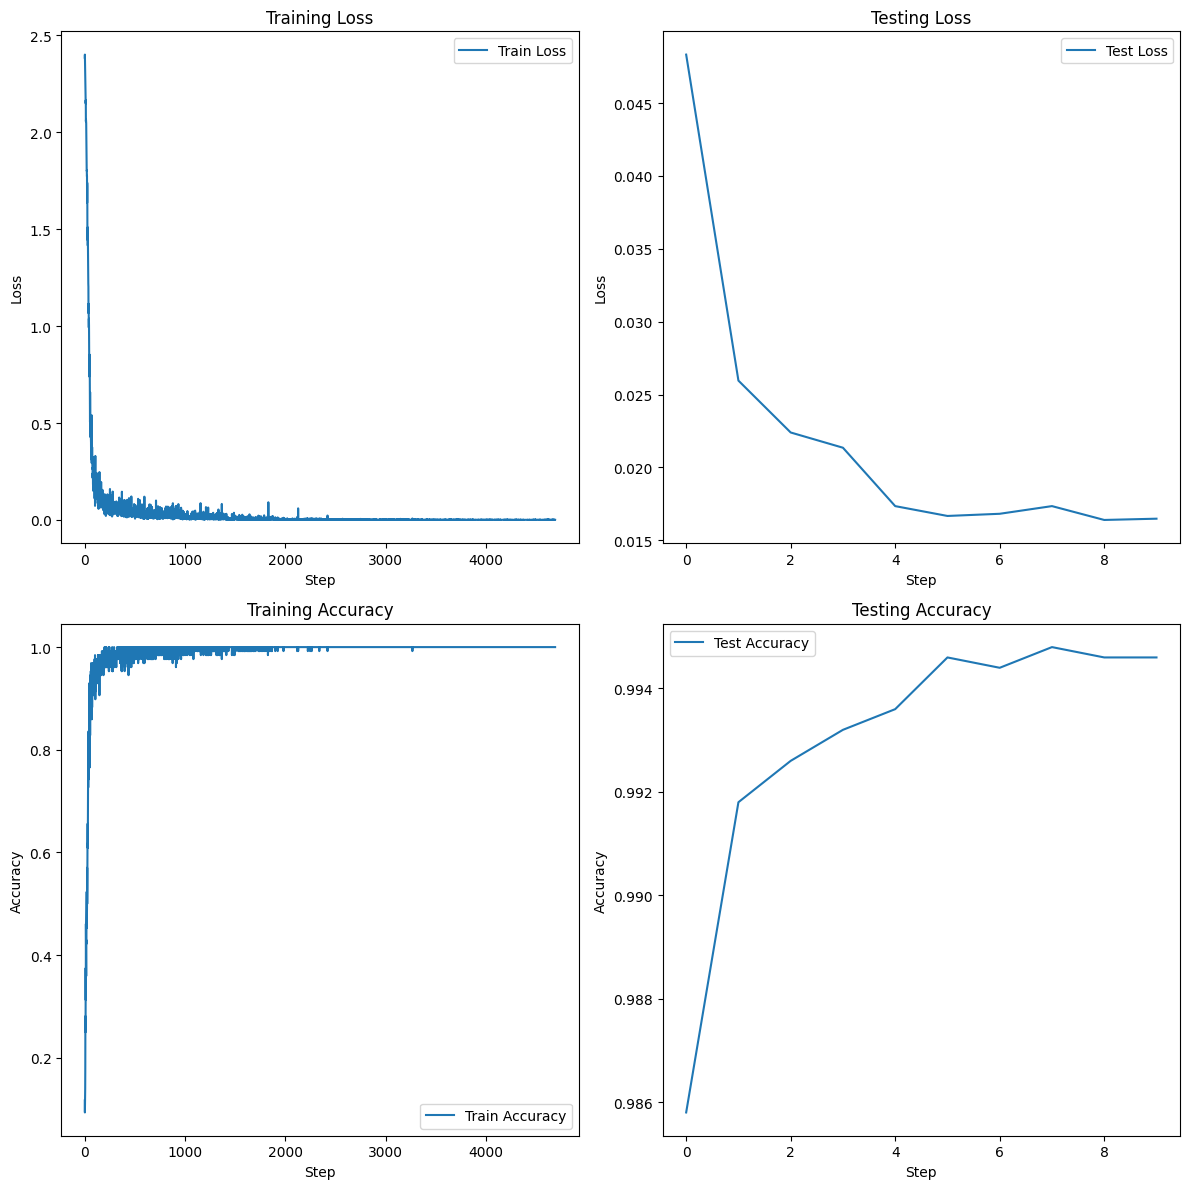

Best Test Accuracy: epoch 7, 0.9947999715805054


(7,
 0.9947999715805054,
 ResNet(
   (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
     (1): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): B

In [12]:
resnet_model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
print(resnet_model)
train(
    net=resnet_model,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=10,
    device=device,
    batch_size=128,
    vis=True,
    save=True,
    lr=1e-3,
    update_epochs=[8]
)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2

[10/10] Test Loss: 0.0212, Test Acc: 0.9927: 100%|██████████| 79/79 [00:00<00:00, 80.02step/s]


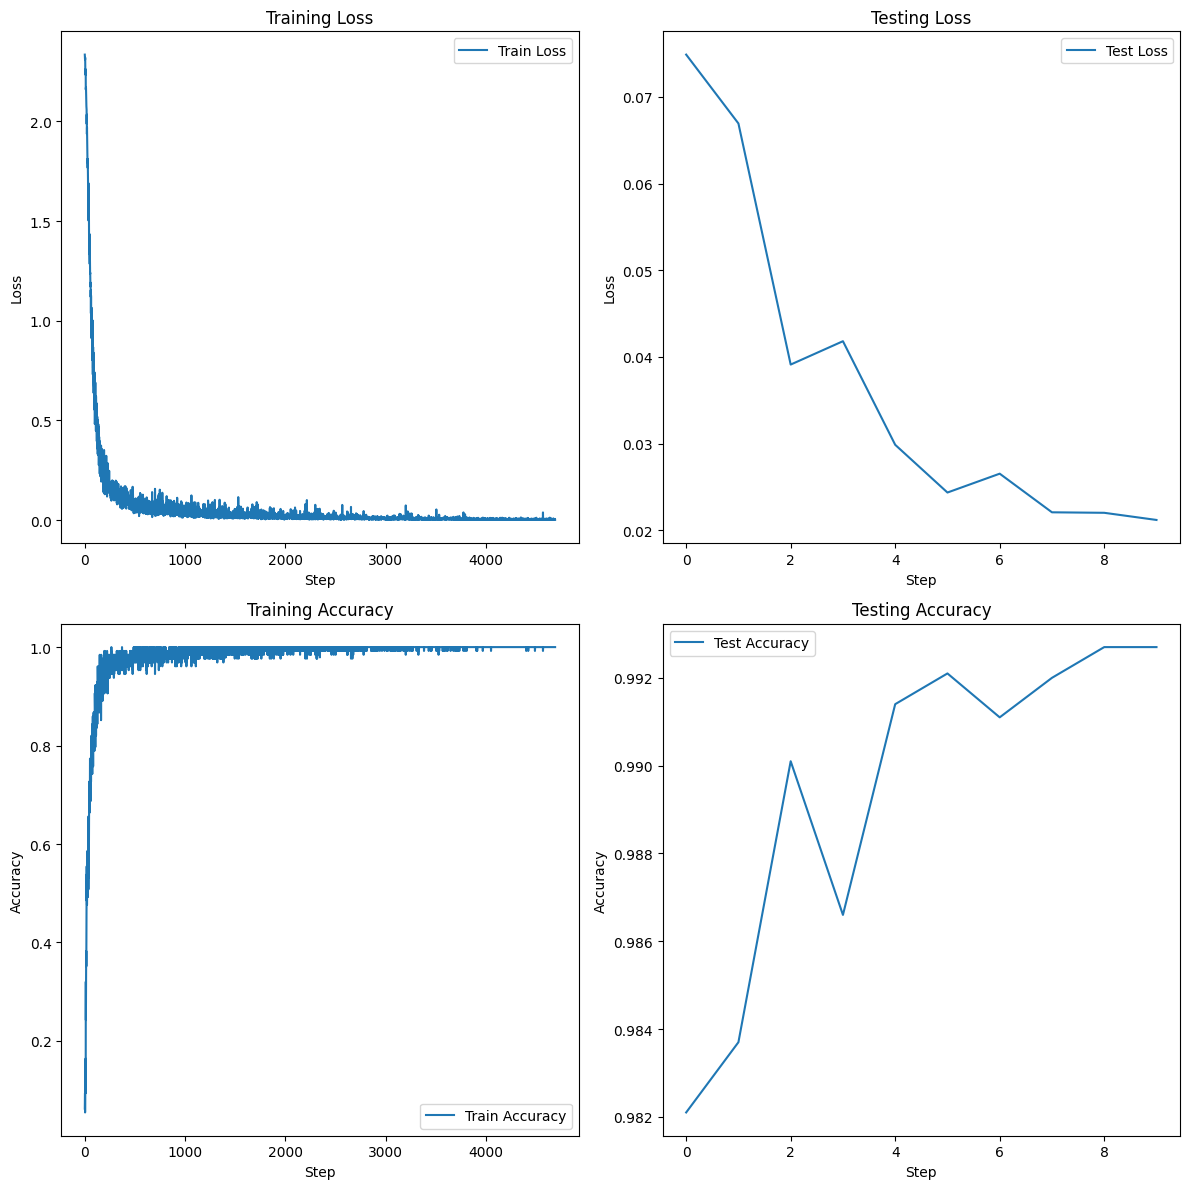

Best Test Accuracy: epoch 8, 0.9926999807357788


(8,
 0.9926999807357788,
 ResNet(
   (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
   )
   (layer2): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

In [27]:
resnet_model = ResNet(ResidualBlock, [1, 1, 1, 1]).to(device)
print(resnet_model)
train(
    net=resnet_model,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=10,
    device=device,
    batch_size=128,
    vis=True,
    save=True,
    lr=1e-3,
    update_epochs=[8]
)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2

[10/10] Test Loss: 0.0191, Test Acc: 0.9931: 100%|██████████| 79/79 [00:01<00:00, 72.73step/s]


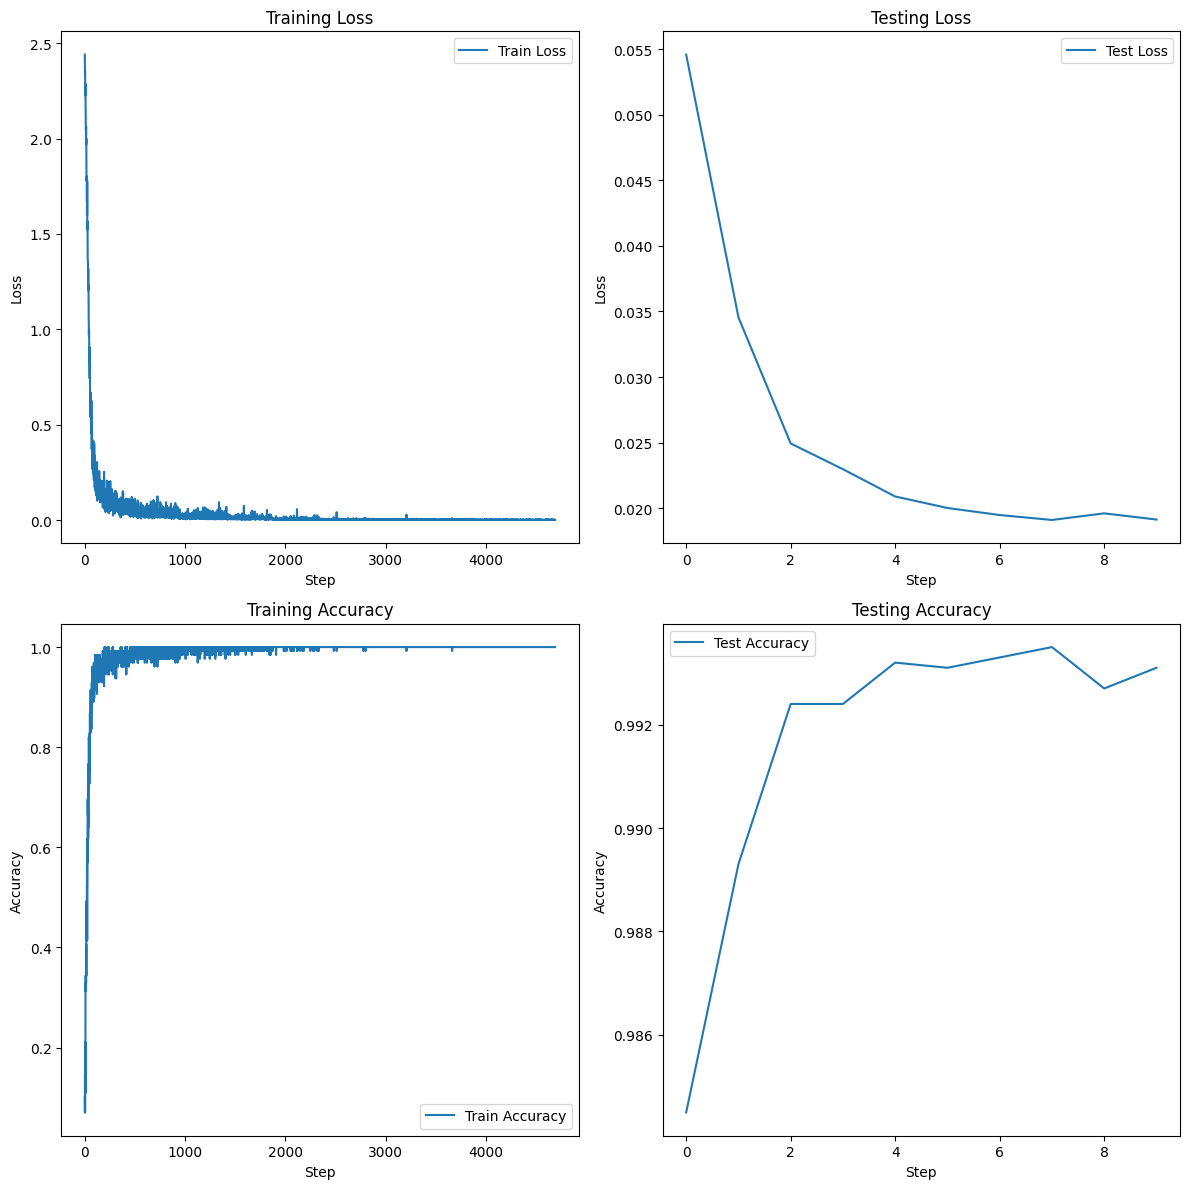

Best Test Accuracy: epoch 7, 0.9934999942779541


(7,
 0.9934999942779541,
 ResNet(
   (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
   )
   (layer2): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

In [33]:
resnet_model = ResNet(ResidualBlock, [1, 1, 1, 2]).to(device)
print(resnet_model)
train(
    net=resnet_model,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=10,
    device=device,
    batch_size=128,
    vis=True,
    save=True,
    lr=1e-3,
    update_epochs=[8]
)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

[10/10] Test Loss: 0.0164, Test Acc: 0.9951: 100%|██████████| 79/79 [00:02<00:00, 34.25step/s]


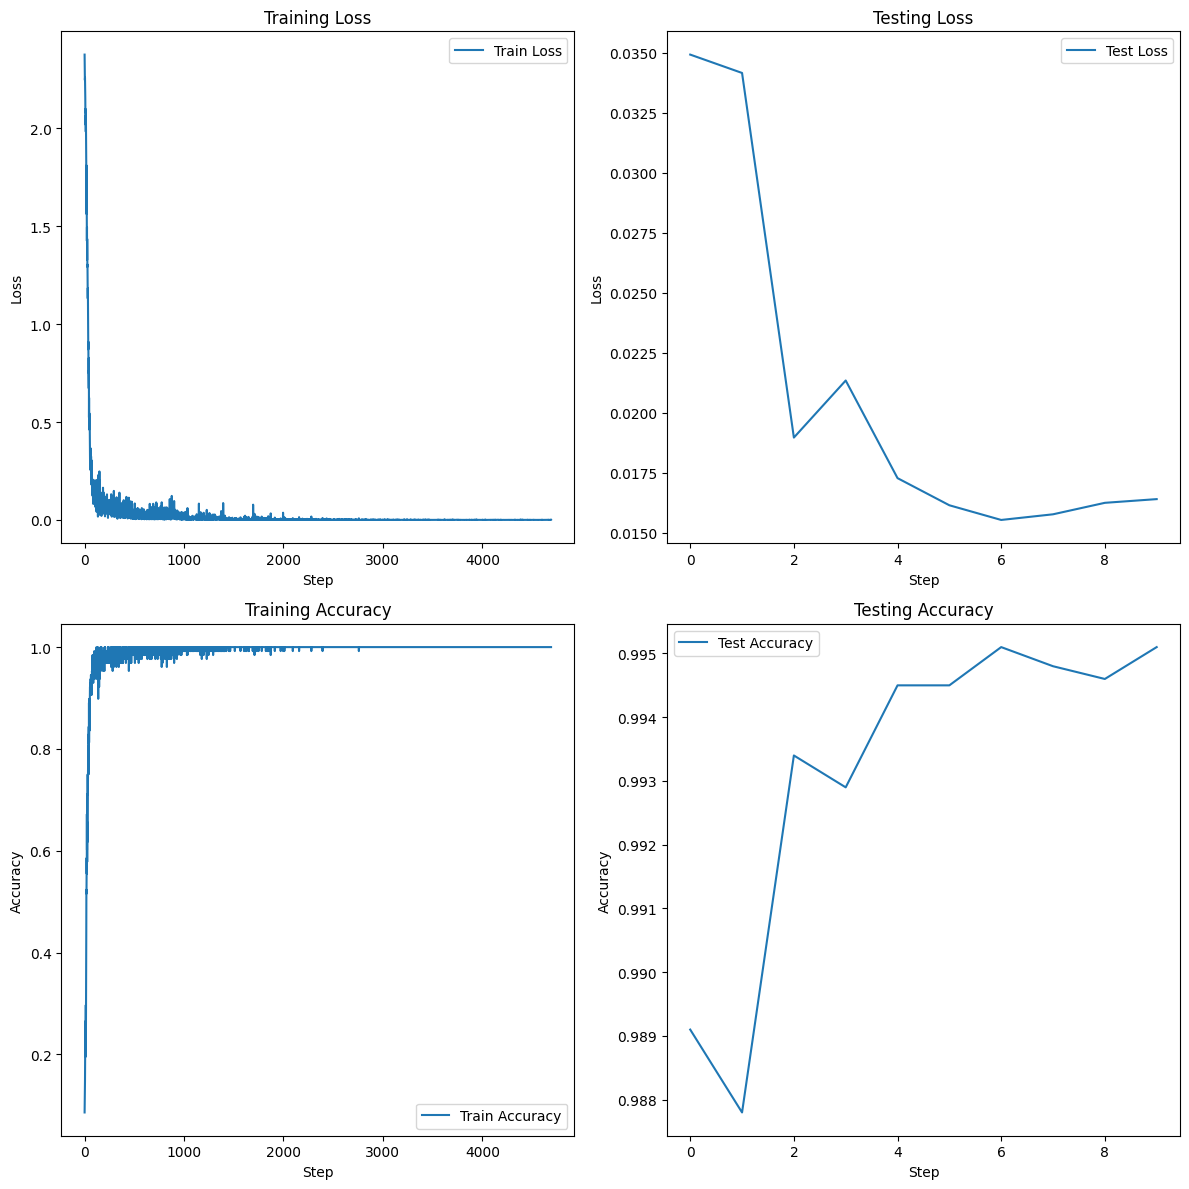

Best Test Accuracy: epoch 6, 0.9950999617576599


(6,
 0.9950999617576599,
 ResNet(
   (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
     (1): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): B

In [28]:
resnet_model = ResNet(ResidualBlock, [3, 3, 3, 3]).to(device)
print(resnet_model)
train(
    net=resnet_model,
    trainDataLoader=trainDataLoader,
    testDataLoader=testDataLoader,
    epochs=10,
    device=device,
    batch_size=128,
    vis=True,
    save=True,
    lr=1e-3,
    update_epochs=[8]
)

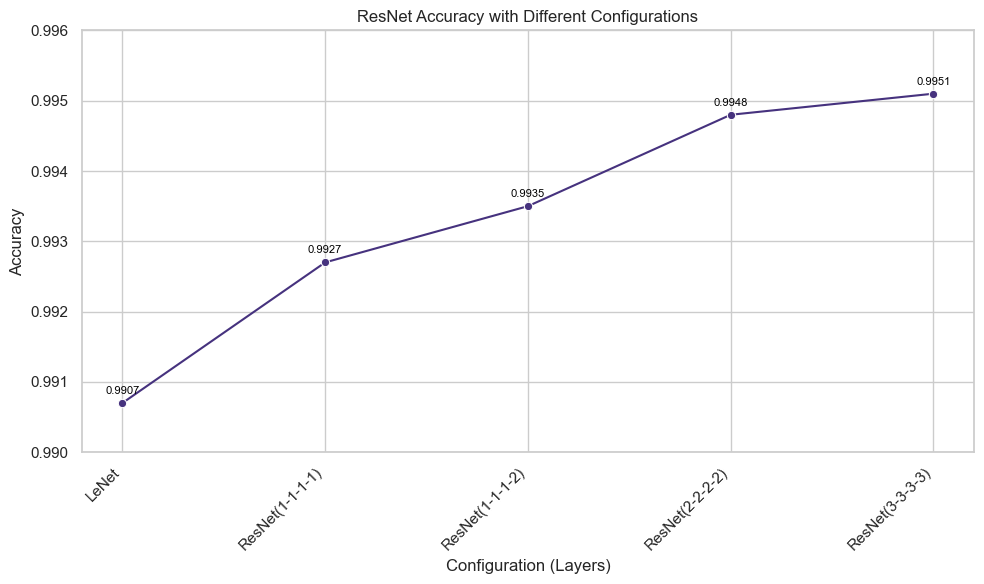

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

resnet_accuracy = {
    'LeNet': 0.9906999468803406,
    'ResNet(1-1-1-1)': 0.9926999807357788,
    'ResNet(1-1-1-2)': 0.9934999942779541,
    'ResNet(2-2-2-2)': 0.9947999715805054,
    'ResNet(3-3-3-3)': 0.9950999617576599
}

# Extracting values from the dictionary
configurations = list(resnet_accuracy.keys())
accuracies = list(resnet_accuracy.values())

# Set seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Plotting the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=configurations, y=accuracies, marker='o')
plt.title('ResNet Accuracy with Different Configurations')
plt.xlabel('Configuration (Layers)')
plt.ylabel('Accuracy')
plt.ylim(0.99, 0.996)  # Set y-axis limits if needed
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Annotating the data points with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.0001, f'{acc:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.show()
